# Coiled Basic Workflows with NASA Earthdata
## Locate data locally, do the rest on the cloud (using kerchunk for optimized access)

### Summary

This notebook processes Earthdata data using the following workflow

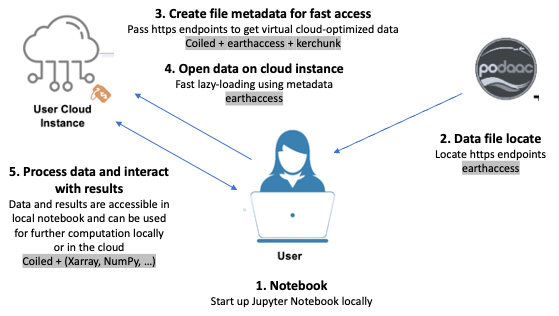

Specifically, the notebook will work with gridded global MUR 1 km sea surface temperature (SST) data to:
1. Log into Earthdata using earthaccess and find the endpoints to 50 MUR 1 km files.
2. Start a remote cluster using Coiled.
3. Create optimized file access metadata, then open the 50 MUR files.
4. Compute the spatial mean over two different regions of the globe for the 50 files on the remote cluster. Then plot the resulting time series.

### earthaccess library requirements

This notebook requires a fix to the earthaccess library which is not part of the standard distribution: https://github.com/nsidc/earthaccess/pull/276

It can be installed with:
```
pip uninstall -y earthaccess
pip install git+https://github.com/jrbourbeau/earthaccess.git@include-store
```

In [1]:
# Access libraries
import s3fs
import requests
import earthaccess

# Parallel computing libraries
import coiled
import dask

# Data analysis libraries
import xarray as xr

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Locate MUR data files using `earthaccess`

**Login to Earthdata**

In [3]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using .netrc file for EDL


**Locate endpoints for first 50 files (will be https endpoints since working locally)**

In [4]:
endpoints = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    #bounding_box=bounding_box,
    #temporal=("2021-04-01", "2021-05-6"),
    count=50,
    )

Granules found: 7749


## 2. Create a remote cluster using `Coiled`

In [ ]:
cluster = coiled.Cluster(
    n_workers=10, 
    account="podaac-science", 
    region="us-west-2", 
    #worker_memory="64 GiB",
    #name='podaac-science-c0a69b8d-e'
    ) 
client = cluster.get_client()

In [ ]:
#client  # Un-comment this line to see client specs.

## 3. Create optimized file access metadata (`earthaccess` + `kerchunk`), then open data

In [5]:
%%time

# Consolidated metdata file
metadata = earthaccess.consolidate_metadata(
    endpoints,
    kerchunk_options={
        "concat_dims": "time", 
        }, 
    #outfile="some S3 path"
)

CPU times: user 661 ms, sys: 226 ms, total: 887 ms
Wall time: 28.7 s


In [6]:
%%time

@dask.delayed
def open_dataset(*args, **kwargs):
    # This is a simple wrapper around Xarray's open_dataset.
    # We use `dask.delayed` to make sure the `xr.open_dataset`
    # call happens on our cluster in us-west-2 so we have proper
    # S3 acess.
    return xr.open_dataset(*args, **kwargs)

fs = earthaccess.get_s3fs_session(daac="PODAAC")
ds = open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "fo": metadata,
            "remote_protocol": "s3",
            "remote_options": fs.storage_options,
        }
    },
).compute()

CPU times: user 732 ms, sys: 39.5 ms, total: 772 ms
Wall time: 9.28 s


In [7]:
ds

<xarray.Dataset>
Dimensions:           (time: 50, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

## 4. Run computations
Compute the spatial mean over two different regions of the globe for the 50 files on the remote cluster. Then plot the resulting time series.

In [10]:
## Bounding boxes for two regions to perform computations over

# Sub-tropical western Atlantic region:
latbnds1 = (20, 30)
lonbnds1 = (-82, -72)

# Mid-latitude eastern Pacific region:
latbnds2 = (45, 55)
lonbnds2 = (-137, -127)

In [9]:
def regional_spatial_mean(sstdata, latbnds, lonbnds):
    """
    Function meant to be run with dask.
    Takes an xarray.DataArray (with dimensions lat, lon), subsets spatially using
    input 2-tuples, returns mean over the subsetted region.
    """
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['lat','lon'], skipna=True) # mean
    return future_result.load()

In [11]:
%%time

# Computations
region1_mean_sst = regional_spatial_mean(ds['analysed_sst'], latbnds1, lonbnds1)
region2_mean_sst = regional_spatial_mean(ds['analysed_sst'], latbnds2, lonbnds2)

CPU times: user 299 ms, sys: 88.5 ms, total: 388 ms
Wall time: 13.7 s


Text(0, 0.5, 'SST [K]')

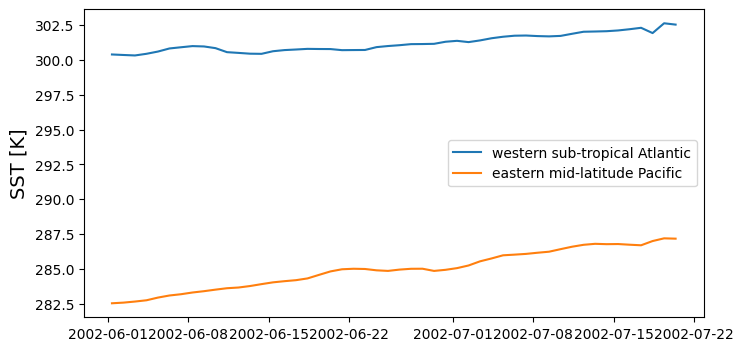

In [12]:
## Plot results

fig = plt.figure(figsize=(8, 4))
axes = plt.axes()

axes.plot(region1_mean_sst['time'], region1_mean_sst.values, label='western sub-tropical Atlantic')
axes.plot(region2_mean_sst['time'], region2_mean_sst.values, label='eastern mid-latitude Pacific')

axes.legend()
axes.set_ylabel('SST [K]', fontsize=14)

In [13]:
cluster.shutdown()